## IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from numpy import loadtxt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import re
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold

# "Support Vector Classifier" 
from sklearn.svm import SVC 
import sklearn.linear_model
import sklearn.svm

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap=ListedColormap(dark2_colors)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import warnings
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

## SOME HELPER FUNCTIONS

In [ ]:
targets = ['zeros', 'ones']
def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)))
    
    #scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'accuracy' , n_jobs = 1)
    #scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='binary')
    acc_score = accuracy_score(y_train, y_pred)
    cm = confusion_matrix(y_pred, y_train)
    specificity = cm[0][0]/ (cm[0][0] + cm[1][0])

    print("\nprecision = %0.3f, recall = %0.3f, specificity= %0.3f F1 = %0.3f, accuracy = %0.3f" % 
          (report[0], report[1], specificity, report[2], acc_score))
    #print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f" % 
    #      (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm, targets)

    pred = clf.predict(x_test)
    y_score = clf.predict_proba(x_test)[:,1]

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)))
    report = precision_recall_fscore_support(y_test, pred, average='binary')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)
    specificity = cm[0][0]/ (cm[0][0] + cm[1][0])
    
    print("\nprecision = %0.3f, recall = %0.3f, specificity= %0.3f F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], specificity, report[2], acc_score))
    print("*********** AUC for ROC = %0.3f *********************\n" % metrics.roc_auc_score(y_test, y_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm, targets)
    
    
def generate_file (model, test_1, file_name):
      preds = model.predict_proba(test_1) #submit these predictions
      # TO CREATE THE FILE FROM PREDICTIONS, preds is returned by pred_proba
      submithis = pd.DataFrame([test_1.index,preds[:,1]]).T
      submithis.columns = ['id','output']
      submithis.id = submithis.id.astype(int)
      submithis.to_csv(file_name,index=False)  #~0.68756
      return submithis
    
    


## LOAD THE DATA AND SOME INITIAL DATA EXPLORATION

In [ ]:
# LOAD THE DATA
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [4]:
print(train.shape)
print(test.shape)

(4584, 670)
(1732, 669)


In [5]:
#pandas_profiling.ProfileReport(train)

In [6]:
train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,...,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,...,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,...,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,...,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,...,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


In [7]:
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,4.665949,0.083412,-17.397081,0.067865,0.005895,0.000012,...,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290,E,4,D
1,0,0,0,0,-398.299487,0.784032,-10.785768,403.784446,0.070405,0.000180,...,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017,H,4,D
2,0,0,0,1,-380.902140,0.671324,-9.265829,361.841929,0.006937,0.000025,...,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553,C,4,B
3,0,0,0,1,-342.784123,0.469414,-8.044287,293.043601,0.007217,-0.000021,...,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359,H,1,C
4,0,0,0,1,6.248502,0.252336,-5.398056,0.110097,0.005573,0.000010,...,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150,E,4,B


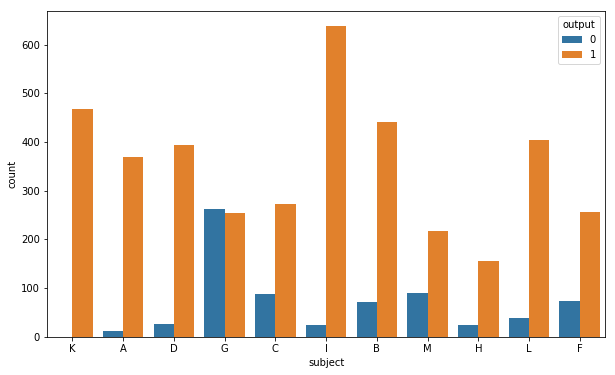

In [8]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="subject", hue="output", data=train);

In [9]:
train.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z215,z216,z217,z218,z219,z220,z221,z222,phase,output
count,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,...,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.0,0.000218,0.000218,0.625436,-270.199043,1.801323,-4.654634,253.735831,0.021039,-0.000004,...,-0.001628,0.001754,0.001374,0.001404,-57.916190,96.554052,-52.630948,28.735112,2.519634,0.844895
std,0.0,0.014770,0.014770,0.484063,163.971643,1.143173,3.714967,147.405918,0.026384,0.000472,...,0.099405,0.070156,0.078443,0.091211,243.742549,597.912778,599.208382,217.842477,1.158998,0.362044
min,0.0,0.000000,0.000000,0.000000,-474.588020,-0.237454,-19.295360,0.026692,0.005007,-0.004008,...,-3.805788,-0.999448,-1.886137,-1.264762,-2182.646032,-6674.270678,-8311.046315,-3671.954955,1.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,-383.328439,0.815996,-6.708809,108.809493,0.007504,-0.000081,...,-0.022183,-0.018118,-0.017379,-0.021389,-31.817506,-1.715924,-11.180312,-0.050475,1.000000,1.000000
50%,0.0,0.000000,0.000000,1.000000,-351.317222,1.578367,-3.324030,313.157669,0.011282,0.000003,...,-0.000383,0.000673,0.000374,0.000507,-2.919292,0.098110,-0.492411,0.001721,3.000000,1.000000
75%,0.0,0.000000,0.000000,1.000000,-177.051209,2.741501,-2.027700,370.832095,0.021861,0.000083,...,0.020556,0.020727,0.019355,0.022440,-0.277689,13.684733,-0.032526,0.483496,4.000000,1.000000
max,0.0,1.000000,1.000000,1.000000,418.085156,4.368496,6.250661,588.309282,0.423408,0.003588,...,0.916725,0.708321,1.548114,2.949784,2408.234281,6111.797852,6412.126601,2816.376179,4.000000,1.000000


In [10]:
test.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z214,z215,z216,z217,z218,z219,z220,z221,z222,phase
count,1732.0,1732.0,1732.0,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,...,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,0.0,0.0,0.0,0.571016,-277.885554,1.604938,-5.414832,255.823559,0.021758,0.000008,...,-0.003202,-0.001151,-0.002507,-0.000998,-0.000054,-110.276709,-121.265455,-222.574598,-38.935670,2.570439
std,0.0,0.0,0.0,0.495074,154.845148,1.147339,4.257535,144.203953,0.026765,0.000373,...,0.136569,0.093555,0.081933,0.089583,0.104841,391.650246,1081.345964,990.468100,319.750306,1.206186
min,0.0,0.0,0.0,0.000000,-467.276129,-0.107885,-20.611523,0.061916,0.004730,-0.002895,...,-1.691499,-1.269537,-1.696589,-0.859393,-1.891506,-3423.935457,-9559.626928,-8897.400348,-2760.528477,1.000000
25%,0.0,0.0,0.0,0.000000,-382.645885,0.604385,-7.819653,137.782812,0.007411,-0.000072,...,-0.026140,-0.022620,-0.021943,-0.018853,-0.022743,-32.187216,-1.156637,-12.301322,-0.030173,1.000000
50%,0.0,0.0,0.0,1.000000,-358.278216,1.351021,-3.725531,324.514646,0.012295,0.000002,...,-0.001551,-0.001223,0.000767,-0.000838,-0.000034,-2.742422,0.185153,-0.486775,0.005631,3.000000
75%,0.0,0.0,0.0,1.000000,-214.315606,2.503754,-2.284565,367.989031,0.024584,0.000082,...,0.023600,0.021058,0.020423,0.017940,0.021003,-0.247839,8.489298,-0.017909,0.352890,4.000000
max,0.0,0.0,0.0,1.000000,411.846894,4.315517,2.279343,554.445563,0.378385,0.002761,...,2.641951,0.810623,0.608914,2.039491,1.835451,1674.130664,5958.441159,5039.275789,2215.886665,4.000000


In [11]:
train_features = train.columns
test_features = test.columns

In [12]:
print(set(train_features)-set(test_features))

{'output'}


In [13]:
train.output.value_counts()

1    3873
0     711
Name: output, dtype: int64

## FEATURE ENGINEERING:   
## ACCOUNT FOR SUBJECT, PHASE & STATE AND REMOVE THE COLUMNS

In [14]:
train['indicator']='train'
test['indicator']='test'

Y = train.output
train.drop('output',inplace=True, axis=1)

In [15]:
train_test = pd.concat([train,test])
train_test.reset_index(inplace=True, drop=True) #drop index
train_test.shape

(6316, 670)

In [16]:
#Creating Features
train_test['SubjectK'] = 0 
train_test.loc[train_test[train_test.subject=='K'].index,'SubjectK']=1  

In [17]:
#Step by step
i1 = train_test[((train_test.phase==1) & (train_test.subject=='A'))].index
arr = np.zeros(train_test.shape[0],dtype=int)
arr[i1]=1
train_test['SubA_Phase1']=arr

#concise
train_test['SubI_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='I'))].index,'SubI_Phase1'] = 1

train_test['SubM_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='M'))].index,'SubM_Phase1'] = 1

train_test['SubA_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='A'))].index,'SubA_Phase2'] = 1

train_test['SubF_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='F'))].index,'SubF_Phase2'] = 1

train_test['SubI_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='I'))].index,'SubI_Phase3'] = 1

train_test['SubL_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='L'))].index,'SubL_Phase3'] = 1

train_test['SubL_Phase4'] = 0
train_test.loc[train_test[((train_test.phase==4) & (train_test.subject=='L'))].index,'SubL_Phase4'] = 1
#possibly add I, phase4 = 1 too.

In [18]:
train_data = train_test[train_test.indicator=='train']
test_output = train_test[train_test.indicator=='test']
train_data.reset_index(inplace=True,drop=True)
test_output.reset_index(inplace=True,drop=True)

train_data = train_data.drop(['state','subject','phase','indicator'], axis=1)
test_output = test_output.drop(['state','subject','phase','indicator'], axis=1)

## SPLIT THE TRAINING DATA INTO TRAIN AND TEST DATA & CREATE A BALANCED DATA SET AS WELL

In [19]:
test_size = 0.15
# SPLIT THE TRAIN DATA INTO TRAIN AND TEST 
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(train_data, Y, test_size=test_size, random_state=101)

# GET A BALANCED VERSION OF THE TRAIN DATA
sm = SMOTE(random_state = 12, ratio = 1.0)
X_train_balanced, y_train_balanced = sm.fit_sample(X_train_unbalanced, y_train_unbalanced)
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_unbalanced.columns)
y_train_balanced = pd.DataFrame(y_train_balanced)

## CHOOSE BETWEEN BALANCED (equal 0s and 1s in output) OR UNBALANCED DATA GOING FORWARD

In [20]:
##################################################
## CHOOSE WHICH DATA SET TO USE GOING FORWARD ####
##################################################
BALANCED = True

if BALANCED : 
    X_train = X_train_balanced 
    y_train = y_train_balanced[0]
else : 
    X_train = X_train_unbalanced
    y_train = y_train_unbalanced   

    
X_test = X_test_unbalanced
y_test = y_test_unbalanced

## RECHECK THE SIZES OF THE TRAINING AND TEST SET

In [21]:
print("TRAINING:")
print(X_train.shape)
print(y_train.shape)
print("0s and 1s split:")
print (y_train.value_counts())

print("\nTEST:")
print(X_test.shape)
print(y_test.shape)
print("0s and 1s split:")
print (y_test.value_counts())

print("\nOutput Test Dataset size:")
print(test_output.shape)

TRAINING:
(6594, 675)
(6594,)
0s and 1s split:
1    3297
0    3297
Name: 0, dtype: int64

TEST:
(688, 675)
(688,)
0s and 1s split:
1    576
0    112
Name: output, dtype: int64

Output Test Dataset size:
(1732, 675)


## STANDARDIZE THE DATA

In [22]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

#Also Standardize the OUTPUT TEST SET FOR LATER USE
test_output_std = std_scale.transform(test_output)

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [23]:
# CHECK TO MAKE SURE THE VARIABLES ARE STANDARDIZED
X_train_std.describe()

,0,1,2,3,4,5,6,7,8,9,...,665,666,667,668,669,670,671,672,673,674
count,6594.0,6594.0,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,...,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03,6.594000e+03
mean,0.0,0.0,-4.978867e-16,1.291022e-15,8.544205e-16,3.672340e-15,3.060942e-17,-3.280226e-15,-3.055912e-16,-2.286447e-17,...,5.707866e-16,-1.154199e-14,3.822301e-15,4.265111e-15,-2.926429e-15,7.861933e-16,-6.111278e-16,1.064905e-14,-3.402251e-15,7.998084e-15
std,0.0,0.0,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,...,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00
min,0.0,0.0,-1.231568e-02,-1.371602e+00,-1.257185e+00,-1.759332e+00,-4.052755e+00,-1.853579e+00,-6.790464e-01,-8.194158e+00,...,-1.989949e+01,-2.507243e-01,-1.169692e-01,-1.169692e-01,-1.149544e-01,-1.142753e-01,-6.983239e-02,-1.445720e-01,-1.202561e-01,-1.412572e-01
25%,0.0,0.0,-1.231568e-02,-1.371602e+00,-6.589886e-01,-8.155264e-01,-6.854817e-01,-8.674241e-01,-5.723995e-01,-1.487970e-01,...,-1.300418e-01,-2.507243e-01,-1.169692e-01,-1.169692e-01,-1.149544e-01,-1.142753e-01,-6.983239e-02,-1.445720e-01,-1.202561e-01,-1.412572e-01
50%,0.0,0.0,-1.231568e-02,8.023330e-01,-4.813618e-01,-2.976463e-01,3.405831e-01,4.144620e-01,-4.100218e-01,1.813041e-02,...,-1.298125e-01,-2.507243e-01,-1.169692e-01,-1.169692e-01,-1.149544e-01,-1.142753e-01,-6.983239e-02,-1.445720e-01,-1.202561e-01,-1.412572e-01
75%,0.0,0.0,-1.231568e-02,8.023330e-01,5.186545e-01,7.297448e-01,7.482515e-01,7.446277e-01,1.154926e-01,1.913332e-01,...,-1.258128e-01,-2.507243e-01,-1.169692e-01,-1.169692e-01,-1.149544e-01,-1.142753e-01,-6.983239e-02,-1.445720e-01,-1.202561e-01,-1.412572e-01
max,0.0,0.0,8.119729e+01,8.023330e-01,4.799720e+00,2.438632e+00,3.117516e+00,2.215881e+00,1.032884e+01,8.789557e+00,...,1.308582e+01,3.988445e+00,8.549262e+00,8.549262e+00,8.699104e+00,8.750798e+00,1.432000e+01,6.916968e+00,8.315584e+00,7.079285e+00


## APPLY PCA TO REDUCE DIMENSION

In [24]:
PCA_components = 130

pca = PCA(n_components=PCA_components)
X_train_PCA = pca.fit_transform(X_train_std)
print(pca.explained_variance_ratio_.sum())

# Transform the test data using the same PCA dimensions
X_test_PCA = pca.transform(X_test_std)

#Also apply PCA to the OUTPUT TEST SET FOR LATER USE
test_output_PCA = pca.transform(test_output_std)

print(X_test_PCA.shape)
print(X_train_PCA.shape)
print(y_test.shape)
print(y_train.shape)
print(test_output_PCA.shape)

0.9465817893080097
(688, 130)
(6594, 130)
(688,)
(6594,)
(1732, 130)


# VARIABLES THAT CAN BE USED WHILE BUILDING THE MODEL 
## UNBALANCED DATA
X_train_unbalanced   
X_test_unbalanced   
y_train_unbalanced   
y_test_unbalanced   

Data Set on which output file is to be generated on:
test_output

## BALANCED DATA
if BALANCE is set to 'TRUE'  
X_train   
y_train   

OR 

X_train_balanced   
y_train_balanced[0]  

Only need to train on balanced data. no need to balance any test data set  
Data Set on which output file is to be generated on:  
test_output

## STANDARDIZED DATA 
if BALANCE is set to 'TRUE' the standardizatoin will happen on BALANCED DATA  

X_train_std   
X_test_std 

Data Set on which output file is to be generated on:  
test_output_std  



## DIMENSIONS REDUCED USING PCA
if BALANCE is set to 'TRUE' the standardizatoin & PCA will be applied on BALANCED DATA  

X_train_PCA  
X_test_PCA  

Data Set on which output file is to be generated on:  
test_output_PCA

## XGBOOST:    
#### DETERMINE NUMBER OF ESTIMATORS USING A LOOP INSTEAD OF GRIDSEARCHCV

In [ ]:
#Create a model on complete training set 
#Leaving CV for your HW
scores = []
for ne in range(700, 1100, 100):
    model = xgb.XGBClassifier(seed=82, n_estimators=ne , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862, eval_metric='auc') #missing = -999
    score_list = cross_val_score(model, X_train, y_train, cv = 5, n_jobs = -1, scoring= 'roc_auc')
    scores.append(score_list)
    #model.fit(train_1,Y, eval_metric='auc')
    #preds = model.predict_proba(test_1) #submit these predictions
#print(preds)


In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
sns.boxplot(x=np.arange(700, 1100, 100),y=scores)
plt.show()

#### FIT A XGBoost MODEL BASED ON THE PARAMETER DETERMINED ABOVE & PRINT STATS

Number of mislabeled points out of a total 6594 training points : 1436
('The hit rate on the training set: ', 0.7822262663026994)

precision = 1.000, recall = 0.564, specificity= 1.000 F1 = 0.722, accuracy = 0.782
          0         1
0  0.696598  0.771628
1  0.000000  1.000000 

The confusion matrix on the training set: 
       0     1
0  3297  1436
1     0  1861


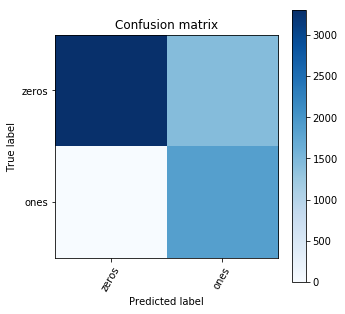

Number of mislabeled points out of a total 688 testing points : 302
('The hit rate on the testing set: ', 0.561046511627907)

precision = 0.945, recall = 0.505, specificity= 0.848 F1 = 0.658, accuracy = 0.561

*********** AUC for ROC = 0.749 *********************

          0         1
0  0.250000  0.925325
1  0.044737  0.944805 

The confusion matrix on the testing set: 
     0    1
0  95  285
1  17  291


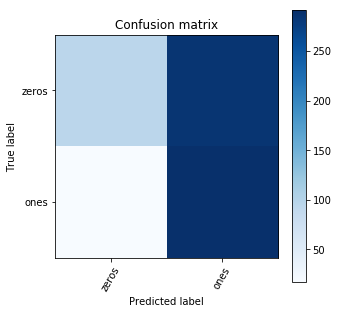

In [25]:
# From the Above scores I pick 700 as the optimal number of estimators.
xgb_model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                        colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                        scale_pos_weight = 0.18357862, eval_metric='auc') #missing = -999

print_stats(xgb_model, X_train, X_test, y_train, y_test)

#### GENERATE FILE FROM THE MODEL TO SUBMIT TO KAGGLE

In [34]:
xgb_model.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, eval_metric='auc', gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=0.18357862, seed=82,
       silent=True, subsample=1)

In [ ]:
_ = generate_file (xgb_model, test_output, "xgb_model.csv") 

#### USE GRIDSEARCHCV TO DETERMINE n_estimators & learning rate for XGBOOST

In [ ]:
# DO A GRIDSEARCH ON XGBOOST MODEL
n_estimators = [ 500, 600, 800, 700, 800, 900, 1000, 1100]  
learning_rate = [0.1, 0.5, 0.01, 0.05,0.001,0.0001]  

param_grid1 = {'learning_rate':learning_rate, 'n_estimators':n_estimators}
param_grid1


In [ ]:
model = xgb.XGBClassifier()
#grid_search = GridSearchCV(model,param_grid=param_grid1, scoring="auc", verbose=1 )
#grid_search.fit(X_train, y_train) #Default 3 folds

In [ ]:
#print(grid_search.best_score_)
#print(grid_search.best_params_)  

## LOGISTIC REGRESSION:

In [35]:
lr_params = [
  {'penalty': ['l1'], 'solver': [ 'liblinear',  'saga']},
  {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag']},
 ]

lr = LogisticRegression()  
grid = GridSearchCV(lr, param_grid = lr_params, cv=3, scoring = 'roc_auc', verbose=1)
grid.fit(X_train_PCA, y_train)

print(grid.best_score_)
print(grid.best_params_)  

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.

0.817365609069706
{'penalty': 'l2', 'solver': 'newton-cg'}


In [62]:
# USE THE BEST PARAMS FOUND BY GRID SEARCH
lr = LogisticRegression(penalty='l2', solver = 'newton-cg')
lr.fit(X_train_PCA, y_train)
lr.score(X_test_PCA, y_test)

0.6584302325581395

In [ ]:
_ = generate_file(lr, pd.DataFrame(test_output_PCA), "logistic_reg.csv")

Number of mislabeled points out of a total 6594 training points : 1553
('The hit rate on the training set: ', 0.7644828632089778)

precision = 0.827, recall = 0.669, specificity= 0.860 F1 = 0.740, accuracy = 0.764
          0         1
0  0.722222  0.408240
1  0.117992  0.826592 

The confusion matrix on the training set: 
       0     1
0  2834  1090
1   463  2207


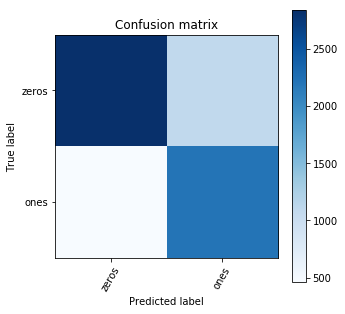

Number of mislabeled points out of a total 688 testing points : 235
('The hit rate on the testing set: ', 0.6584302325581395)

precision = 0.913, recall = 0.655, specificity= 0.679 F1 = 0.762, accuracy = 0.658

*********** AUC for ROC = 0.751 *********************

          0         1
0  0.276364  0.481840
1  0.130909  0.912833 

The confusion matrix on the testing set: 
     0    1
0  76  199
1  36  377


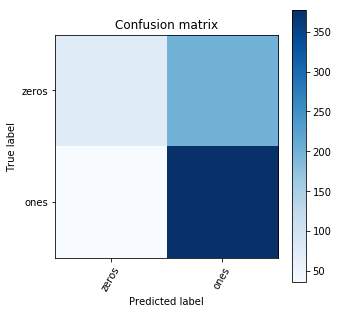

In [63]:
print_stats(lr, X_train_PCA, X_test_PCA, y_train, y_test)

## NAIVE BAYES

Number of mislabeled points out of a total 6594 training points : 1910
('The hit rate on the training set: ', 0.7103427358204428)

precision = 0.798, recall = 0.564, specificity= 0.857 F1 = 0.661, accuracy = 0.710
          0         1
0  0.662603  0.617862
1  0.110434  0.797767 

The confusion matrix on the training set: 
       0     1
0  2826  1439
1   471  1858


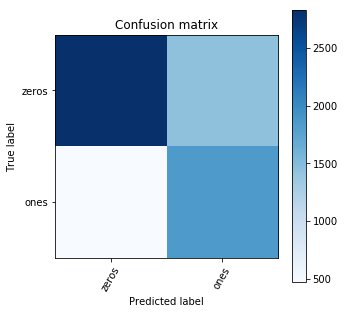

Number of mislabeled points out of a total 688 testing points : 287
('The hit rate on the testing set: ', 0.5828488372093024)

precision = 0.905, recall = 0.561, specificity= 0.696 F1 = 0.692, accuracy = 0.583

*********** AUC for ROC = 0.635 *********************

          0         1
0  0.235650  0.708683
1  0.102719  0.904762 

The confusion matrix on the testing set: 
     0    1
0  78  253
1  34  323


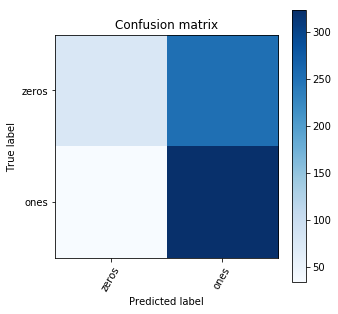

GaussianNB(priors=None, var_smoothing=1e-09)

In [64]:
gnb = GaussianNB()

print_stats(gnb, X_train, X_test, y_train, y_test)

gnb.fit(X_train, y_train)


## RANDOM FOREST

In [26]:
# DO A GRIDSEARCH ON XGBOOST MODEL
n_estimators = [ 50, 60, 70, 80, 90]  
max_features = [5, 6]  
min_samples_leaf = [10,50, 200,500]

param_RandomForest = {'n_estimators':n_estimators, 'max_features':max_features, 'min_samples_leaf': min_samples_leaf}
param_RandomForest


{'n_estimators': [50, 60, 70, 80, 90],
 'max_features': [5, 6],
 'min_samples_leaf': [10, 50, 200, 500]}

In [27]:
model = RandomForestClassifier()
#grid_search = GridSearchCV(model, param_grid=param_RandomForest, scoring="roc_auc", verbose=1 )
#grid_search.fit(X_train, y_train) #Default 3 folds

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70, 80, 90], 'max_features': [5, 6], 'min_samples_leaf': [10, 50, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [28]:
print(grid_search.best_score_)
print(grid_search.best_params_)  

0.946857139545339
{'max_features': 6, 'min_samples_leaf': 10, 'n_estimators': 80}


Number of mislabeled points out of a total 6594 training points : 124
('The hit rate on the training set: ', 0.981195025781013)

precision = 0.973, recall = 0.989, specificity= 0.973 F1 = 0.981, accuracy = 0.981
          0         1
0  0.989208  0.010445
1  0.027444  0.973441 

The confusion matrix on the training set: 
       0     1
0  3208    35
1    89  3262


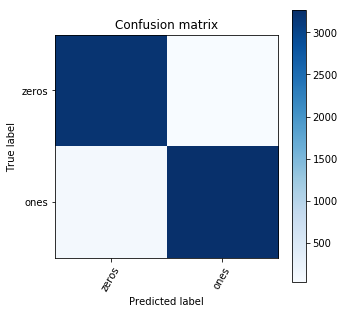

Number of mislabeled points out of a total 688 testing points : 122
('The hit rate on the testing set: ', 0.8226744186046512)

precision = 0.871, recall = 0.925, specificity= 0.295 F1 = 0.897, accuracy = 0.823

*********** AUC for ROC = 0.686 *********************

          0         1
0  0.434211  0.070261
1  1.039474  0.870915 

The confusion matrix on the testing set: 
     0    1
0  33   43
1  79  533


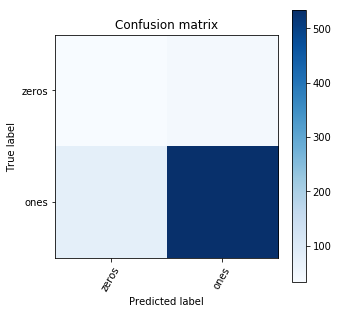

In [73]:
rf = RandomForestClassifier(max_features = 10, n_estimators = 80, min_samples_leaf =10)
print_stats(rf, X_train, X_test, y_train, y_test)

In [74]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## STACK THE RESULTS OF DIFFERENT MODELS

In [75]:
def create_base_predictions (list_data):
    return_list = []
    for X, X_PCA in list_data:
        base_predictions = pd.DataFrame( 
          {#'XGBoost': list(xgb_model.predict_proba(X)[:,1]),
           'LogisticR': list(lr.predict_proba(X_PCA)[:,1]),
           'NaiveBayes': list(gnb.predict_proba(X)[:,1]),
           'RandomForeset': list(rf.predict_proba(X)[:,1])
          })
        return_list.append(base_predictions)
    return return_list[0], return_list[1], return_list[2]
        
data_list = [(X_train, X_train_PCA), (X_test, X_test_PCA), (test_output, test_output_PCA)]

training_preds, test_preds, output_preds= create_base_predictions(data_list)

print(training_preds.shape)
print(y_train.shape)
print(y_train.value_counts())
print(test_preds.shape)
print(y_test.shape)
print(y_test.value_counts())
print(output_preds.shape)

(6594, 3)
(6594,)
1    3297
0    3297
Name: 0, dtype: int64
(688, 3)
(688,)
1    576
0    112
Name: output, dtype: int64
(1732, 3)


Number of mislabeled points out of a total 6594 training points : 119
('The hit rate on the training set: ', 0.9819532908704883)

precision = 0.978, recall = 0.986, specificity= 0.978 F1 = 0.982, accuracy = 0.982
          0         1
0  0.985636  0.014148
1  0.022005  0.978326 

The confusion matrix on the training set: 
       0     1
0  3225    47
1    72  3250


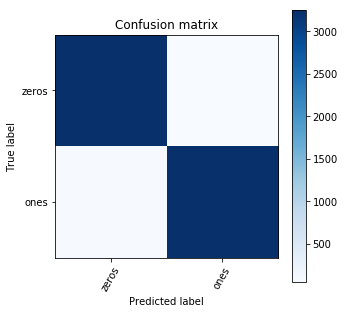

Number of mislabeled points out of a total 688 testing points : 139
('The hit rate on the testing set: ', 0.7979651162790697)

precision = 0.865, recall = 0.899, specificity= 0.277 F1 = 0.882, accuracy = 0.798

*********** AUC for ROC = 0.730 *********************

          0         1
0  0.348315  0.096828
1  0.910112  0.864775 

The confusion matrix on the testing set: 
     0    1
0  31   58
1  81  518


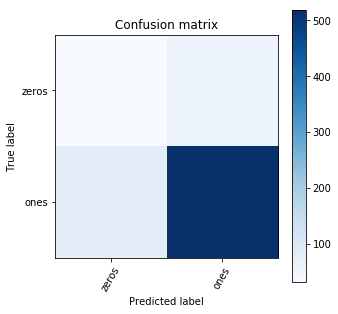

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
gbm_stack = xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators= 700,
 max_depth= 6,  
 min_child_weight= 2,
 gamma=0.9,   #Regularization parameter                     
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)


rf_stack = RandomForestClassifier(max_features = 1, n_estimators = 50, min_samples_leaf =50)


# PRINT STATS AND FIT ON THE TRAINING SET
print_stats(rf_stack, training_preds, test_preds, y_train, y_test)
rf_stack.fit(training_preds, y_train)

In [79]:
_ = generate_file (rf_stack, output_preds, "stack.csv") 